In [90]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy.stats import shapiro
import time
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.model_selection import KFold, cross_val_score

In [91]:
my_seed = 9212
plt = mpl.pyplot

In [92]:
fileURL = 'https://raw.githubusercontent.com/ania607/ML/refs/heads/main/data/College_for_lab.csv'
df_raw = pd.read_csv(fileURL)
df_raw

,Grad_Rate,Accept,Top10perc,Top25perc,F_Undergrad,P_Undergrad,PhD,Expend,Private
0,60,1232,23,52,2885,537,70,7041,Yes
1,56,1924,16,29,2683,1227,29,10527,Yes
2,54,1097,22,50,1036,99,53,8735,Yes
3,59,349,60,89,510,63,92,19016,Yes
4,15,146,16,44,249,869,76,10922,Yes
...,...,...,...,...,...,...,...,...,...
772,40,1515,4,26,3089,2029,60,4469,No
773,83,1805,24,47,2849,1107,73,9189,Yes
774,49,1915,34,61,2793,166,67,8323,Yes
775,99,2453,95,99,5217,83,96,40386,Yes


In [93]:
df_raw.dtypes

,0
Grad_Rate,int64
Accept,int64
Top10perc,int64
Top25perc,int64
F_Undergrad,int64
P_Undergrad,int64
PhD,int64
Expend,int64
Private,object


###Проверим, есть в таблице пропуски

In [94]:
df_raw.isna().sum()

,0
Grad_Rate,0
Accept,0
Top10perc,0
Top25perc,0
F_Undergrad,0
P_Undergrad,0
PhD,0
Expend,0
Private,0


In [95]:
df_raw['Private'] = df_raw['Private'].apply(lambda x: 1 if x == 'Yes' else 0)
df_raw['Private']

,Private
0,1
1,1
2,1
3,1
4,1
...,...
772,0
773,1
774,1
775,1


In [96]:
df = df_raw[['Grad_Rate', 'Expend', 'P_Undergrad', 'Private']]
df

,Grad_Rate,Expend,P_Undergrad,Private
0,60,7041,537,1
1,56,10527,1227,1
2,54,8735,99,1
3,59,19016,63,1
4,15,10922,869,1
...,...,...,...,...
772,40,4469,2029,0
773,83,9189,1107,1
774,49,8323,166,1
775,99,40386,83,1


###Разделяем данные на обучающую (df_train) и тестовую (df_predict) выборки в соотношении 80/20.

In [97]:
df_train = df.sample(frac=0.8, random_state=my_seed)
df_predict = df.drop(df_train.index)

In [98]:
df_train.describe()

,Grad_Rate,Expend,P_Undergrad,Private
count,622.000000,622.000000,622.000000,622.000000
mean,64.911576,9682.720257,864.281350,0.733119
std,17.296046,5414.968113,1581.024769,0.442686
min,10.000000,3186.000000,1.000000,0.000000
25%,53.000000,6742.500000,95.000000,0.000000
50%,65.000000,8412.000000,363.500000,1.000000
75%,77.000000,10807.750000,966.000000,1.000000
max,118.000000,56233.000000,21836.000000,1.000000


###Построим парные графики рассеяния и графики распределения


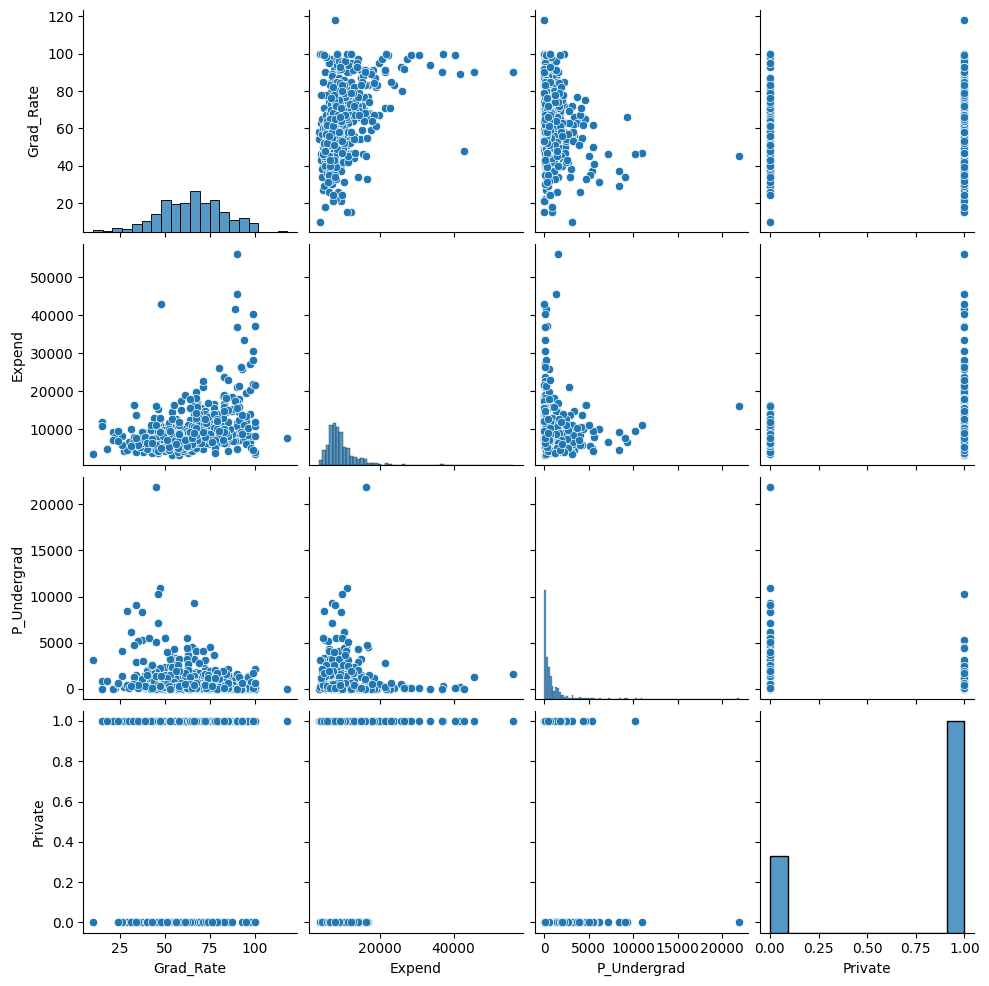

In [99]:
sns.pairplot(df_train)
plt.show()

На обоих графиках очевидно, что влияние расходов ($\text{Expend}$) и процента студентов ($\text{P\_Undergrad}$) на рейтинг выпуска ($\text{Grad_Rate}$) зависит от того, частный колледж или государственный ($\text{Private}$).График $\text{Expend}$: связь нелинейна (логарифмическая — рост замедляется), и наклон тренда для частных (оранжевых) колледжей отличается от государственных (синих). Это требует использования $\mathbf{\ln(\text{Expend})}$ и члена взаимодействия $\mathbf{\ln(\text{Expend}) \cdot \text{Private}}$ в модели.График $\text{P_Undergrad}$: Различие в наклонах между частными и государственными колледжами также видно, что требует включения члена взаимодействия $\mathbf{\text{P_Undergrad} \cdot \text{Private}}$ в модель.

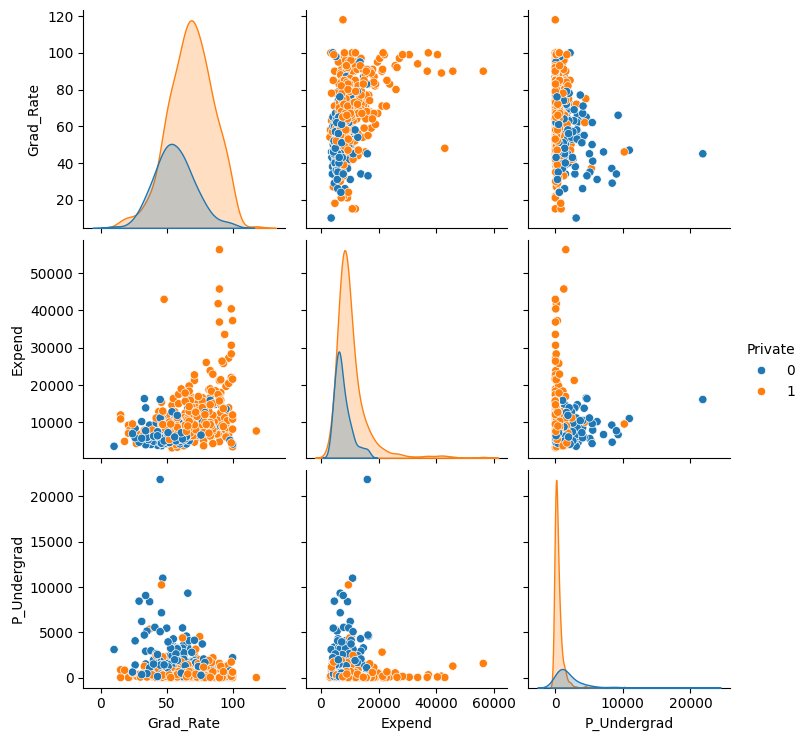

In [100]:
sns.pairplot(df_train, hue='Private')
plt.show()

In [101]:
corr_mat = df_train.corr()
corr_mat.style.background_gradient(cmap='coolwarm')

,Grad_Rate,Expend,P_Undergrad,Private
Grad_Rate,1.000000,0.380961,-0.232131,0.315537
Expend,0.380961,1.000000,-0.062934,0.233817
P_Undergrad,-0.232131,-0.062934,1.000000,-0.435876
Private,0.315537,0.233817,-0.435876,1.000000


In [102]:
corr_mat = df_train[df_train['Private'] == 1].drop(['Private'], axis=1).corr()
corr_mat.style.background_gradient(cmap='coolwarm')

,Grad_Rate,Expend,P_Undergrad
Grad_Rate,1.000000,0.350960,-0.060909
Expend,0.350960,1.000000,-0.071168
P_Undergrad,-0.060909,-0.071168,1.000000


In [103]:
corr_mat = df_train[df_train['Private'] == 0].drop(['Private'], axis=1).corr()
corr_mat.style.background_gradient(cmap='coolwarm')

,Grad_Rate,Expend,P_Undergrad
Grad_Rate,1.000000,0.276503,-0.203411
Expend,0.276503,1.000000,0.306369
P_Undergrad,-0.203411,0.306369,1.000000


In [104]:
df_train['log_Grad_Rate'] = np.log(df_train['Grad_Rate'])

In [105]:
for col in df_train.columns:
 stat, p = shapiro(df_train[col])
 print(col, 'Statistics=%.2f, p=%.4f' % (stat, p))
 # интерпретация
 alpha = 0.05
 if p > alpha:
  print('Распределение нормально (H0 не отклоняется)\n')
 else:
  print('Распределение не нормально (H0 отклоняется)\n')


Grad_Rate Statistics=1.00, p=0.0707
Распределение нормально (H0 не отклоняется)

Expend Statistics=0.69, p=0.0000
Распределение не нормально (H0 отклоняется)

P_Undergrad Statistics=0.50, p=0.0000
Распределение не нормально (H0 отклоняется)

Private Statistics=0.55, p=0.0000
Распределение не нормально (H0 отклоняется)

log_Grad_Rate Statistics=0.93, p=0.0000
Распределение не нормально (H0 отклоняется)



In [106]:
df_train['log_Expend'] = np.log(df_train['Expend'])

## Создание датафреймов для различных моделей линейной регрессии

Спецификация моделей:

1.  **fit_lm_1**: $ {Grad\_Rate} = \widehat{\beta}_0 + \widehat{\beta}_1 \cdot \text{Expend} + \widehat{\beta}_2 \cdot \text{P_Undergrad} + \widehat{\beta}_3 \cdot \text{Private} $
2.  **fit_lm_2**: $ {Grad\_Rate} = \widehat{\beta}_0 + \widehat{\beta}_1 \cdot \ln(\text{Expend}) + \widehat{\beta}_2 \cdot \text{P_Undergrad} + \widehat{\beta}_3 \cdot \text{Private} $
3.  **fit_lm_3**: $ {Grad\_Rate} = \widehat{\beta}_0 + \widehat{\beta}_1 \cdot \ln(\text{Expend}) + \widehat{\beta}_2 \cdot \text{P_Undergrad} + \widehat{\beta}_3 \cdot \text{Private} + \widehat{\beta}_4 \cdot \ln(\text{Expend}) \cdot \text{Private} $
4.  **fit_lm_4**: $ {Grad\_Rate} = \widehat{\beta}_0 + \widehat{\beta}_1 \cdot \ln(\text{Expend}) + \widehat{\beta}_2 \cdot \text{P_Undergrad} + \widehat{\beta}_3 \cdot \text{Private} + \widehat{\beta}_4 \cdot \ln(\text{Expend}) \cdot \text{Private} + \widehat{\beta}_5 \cdot \text{P_Undergrad} \cdot \text{Private} $
5.  **fit_lm_1_log**: $ \ln({Grad\_Rate}) = \widehat{\beta}_0 + \widehat{\beta}_1 \cdot \text{Expend} + \widehat{\beta}_2 \cdot \text{P_Undergrad} + \widehat{\beta}_3 \cdot \text{Private} $
6.  **fit_lm_2_log**: $ \ln({Grad\_Rate}) = \widehat{\beta}_0 + \widehat{\beta}_1 \cdot \ln(\text{Expend}) + \widehat{\beta}_2 \cdot \text{P_Undergrad} + \widehat{\beta}_3 \cdot \text{Private} $
7.  **fit_lm_3_log**: $ \ln({Grad\_Rate}) = \widehat{\beta}_0 + \widehat{\beta}_1 \cdot \ln(\text{Expend}) + \widehat{\beta}_2 \cdot \text{P_Undergrad} + \widehat{\beta}_3 \cdot \text{Private} + \widehat{\beta}_4 \cdot \ln(\text{Expend}) \cdot \text{Private} $
8.  **fit_lm_4_log**: $ \ln({Grad\_Rate}) = \widehat{\beta}_0 + \widehat{\beta}_1 \cdot \ln(\text{Expend}) + \widehat{\beta}_2 \cdot \text{P_Undergrad} + \widehat{\beta}_3 \cdot \text{Private} + \widehat{\beta}_4 \cdot \ln(\text{Expend}) \cdot \text{Private} + \widehat{\beta}_5 \cdot \text{P_Undergrad} \cdot \text{Private} $

## Обучение и интерпретация:
Создаём матрицы значений объясняющих переменных ($\mathbf{X}$) и вектора значений зависимой ($\mathbf{y}$) для всех моделей.

In [107]:
df_LM1 = df_train[['Grad_Rate', 'Expend', 'P_Undergrad', 'Private']].copy()


# LM_2: Grad_Rate ~ log_Expend + P_Undergrad + Private
df_LM2 = df_train[['Grad_Rate', 'log_Expend', 'P_Undergrad', 'Private']].copy()


# LM_3: Grad_Rate ~ log_Expend + P_Undergrad + Private + log_Expend * Private
df_LM3 = df_train[['Grad_Rate', 'log_Expend', 'P_Undergrad', 'Private']].copy()
df_LM3.loc[:, 'log_Expend_Private'] = df_LM3.loc[:, 'log_Expend'] * df_LM3.loc[:, 'Private']


# LM_4: Grad_Rate ~ LM3 + P_Undergrad * Private
df_LM4 = df_LM3.copy()
df_LM4.loc[:, 'P_Undergrad_Private'] = df_LM4.loc[:, 'P_Undergrad'] * df_LM4.loc[:, 'Private']

In [108]:
lm = skl_lm.LinearRegression()


X = df_LM1.drop(['Grad_Rate'], axis=1)
y = df_LM1['Grad_Rate'].values.reshape(-1, 1)
fit_lm_0 = lm.fit(X, y)

print('модель fit_lm_1:\n',
 'константа ', np.around(fit_lm_0.intercept_, 3),
 '\n объясняющие ', list(X.columns.values),
 '\n коэффициенты ', np.around(fit_lm_0.coef_, 3)
)

модель fit_lm_1:
 константа  [50.778] 
 объясняющие  ['Expend', 'P_Undergrad', 'Private'] 
 коэффициенты  [[ 1.00e-03 -1.00e-03  7.05e+00]]


In [109]:
y_pred = fit_lm_0.predict(X)
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
MSE

array([234.87149141])

In [110]:
lm = skl_lm.LinearRegression()


X = df_LM1.drop(['Grad_Rate'], axis=1)
y = np.log(df_LM1['Grad_Rate']).values.reshape(-1, 1)
fit_lm_0_log = lm.fit(X, y)

print('модель fit_lm_1_log:\n',
 'константа ', np.around(fit_lm_0_log.intercept_, 3),
 '\n объясняющие ', list(X.columns.values),
 '\n коэффициенты ', np.around(fit_lm_0_log.coef_, 3)
 )

модель fit_lm_1_log:
 константа  [3.912] 
 объясняющие  ['Expend', 'P_Undergrad', 'Private'] 
 коэффициенты  [[ 0.    -0.     0.115]]


In [111]:
np.round(np.exp(fit_lm_0_log.intercept_), 1)

array([50.])

In [112]:
np.round((np.exp(fit_lm_0_log.coef_) - 1) * 100, 1)

array([[ 0. , -0. , 12.2]])

In [113]:
y_pred = fit_lm_0_log.predict(X)
MSE_log = sum((np.exp(y) - np.exp(y_pred).reshape(-1, 1))**2) / len(y)
MSE_log

array([246.21326576])

In [114]:
loo = LeaveOneOut()
scores = list()
tic = time.perf_counter()
for df in [df_LM1, df_LM2, df_LM3, df_LM4] :
 loo.get_n_splits(df)
 X = df.drop(['Grad_Rate'], axis=1)
 y = df['Grad_Rate']
 score = cross_val_score(lm, X, y, cv=loo,
 scoring='neg_mean_squared_error').mean()
 scores.append(score)

toc = time.perf_counter()
print(f"Расчёты методом LOOCV заняли {toc - tic:0.2f} секунд")

Расчёты методом LOOCV заняли 9.90 секунд


In [115]:
scores_log = list()
tic = time.perf_counter()
for df in [df_LM1, df_LM2, df_LM3, df_LM4]:
 loo.get_n_splits(df)
 X = df.drop(['Grad_Rate'], axis=1)
 y = np.log(df['Grad_Rate'])
 score = cross_val_score(lm, X, y, cv=loo, n_jobs=1,
 scoring='neg_mean_squared_error').mean()
 scores_log.append(score)

toc = time.perf_counter()
print(f"Расчёты методом LOOCV заняли {toc - tic:0.2f} секунд")

Расчёты методом LOOCV заняли 9.77 секунд


In [116]:
[np.around(-x, 2) for x in scores]

[np.float64(238.29),
 np.float64(232.13),
 np.float64(232.96),
 np.float64(233.93)]

In [117]:
[np.around(-x, 3) for x in scores_log]

[np.float64(0.078), np.float64(0.076), np.float64(0.076), np.float64(0.076)]

In [80]:
fits = ['fit_lm_1', 'fit_lm_2', 'fit_lm_3', 'fit_lm_4']
print('Наименьшая ошибка на тестовой с LOOCV у модели',
 fits[scores.index(max(scores))],
 ':\nMSE_loocv =', np.around(-max(scores), 1)
)

Наименьшая ошибка на тестовой с LOOCV у модели fit_lm_2 :
MSE_loocv = 232.1


In [81]:
fits = ['fit_lm_1_log', 'fit_lm_2_log','fit_lm_3_log', 'fit_lm_4_log']
print('Наименьшая ошибка на тестовой с LOOCV у модели',
 fits[scores_log.index(max(scores_log))],
 ':\nMSE_loocv =', np.around(-max(scores_log), 3))


Наименьшая ошибка на тестовой с LOOCV у модели fit_lm_2_log :
MSE_loocv = 0.076


In [83]:
df_predict['log_Expend'] = np.log(df_predict['Expend'])

In [85]:
X = df_LM2.drop(['Grad_Rate'], axis=1)
y = df_LM2['Grad_Rate'].values.reshape(-1, 1)
fit_lm_2 = lm.fit(X, y)

y = df_predict[['Grad_Rate']].values.reshape(-1, 1)
X = df_predict[['log_Expend', 'P_Undergrad', 'Private']].copy()

y_pred = fit_lm_2.predict(X)

MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
print('MSE модели fit_lm_2 на отложенных наблюдениях = %.2f' % MSE)

MSE модели fit_lm_2 на отложенных наблюдениях = 200.87


/tmp/ipython-input-761455655.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('MSE модели fit_lm_2 на отложенных наблюдениях = %.2f' % MSE)


In [88]:
print('Ошибка модели на отложенных наблюдениях составила ',
 np.around(np.sqrt(MSE) / np.mean(y) * 100, 1)[0], '% от cреднего значения Y',
 sep='')

Ошибка модели на отложенных наблюдениях составила 20.9% от cреднего значения Y


In [118]:
fit_lm_2.coef_

array([[ 1.53511663e+01, -1.54790799e-03,  5.59218816e+00]])